In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
import pandas as pd
from ast import literal_eval
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)

Using TensorFlow backend.


In [2]:
class DCGAN():
  
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.img_shape = (self.img_rows, self.img_cols, 1)
        self.latent_dim = 100

        self.optimizer = Adam(0.0002, 0.5)

          # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

          # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.gan = self.build_GAN()
  
    def build_GAN(self):
        self.discriminator.trainable = False
        gan_input = Input(shape=(self.latent_dim,))
        img = self.generator(gan_input)

        gan_output = self.discriminator(img)
        gan = Model(gan_input, gan_output, name='GAN')
        gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        gan.summary()

        return gan
    
    def build_generator(self):
    
        generator = Sequential()
        generator.add(Dense(128 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        generator.add(Reshape((16, 16, 128)))
        generator.add(BatchNormalization(momentum=0.8))
        generator.add(UpSampling2D())
        generator.add(Conv2D(128, kernel_size=3, padding="same"))
        generator.add(LeakyReLU(0.2))
        generator.add(BatchNormalization(momentum=0.8))
        generator.add(UpSampling2D())
        generator.add(Conv2D(64, kernel_size=3, padding="same"))
        generator.add(LeakyReLU(0.2))
        generator.add(BatchNormalization(momentum=0.8))
        generator.add(Conv2D(1, kernel_size=3, padding='same', activation = "tanh"))
        generator.summary()

        noise = Input(shape=(self.latent_dim,))
        img = generator(noise)

        return Model(noise, img, name='Generator')

    def build_discriminator(self):

        discriminator = Sequential()
        discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                                   input_shape=self.img_shape, kernel_initializer=RandomNormal(stddev=0.02)))
        discriminator.add(LeakyReLU(0.2))
        discriminator.add(Dropout(0.2))
        discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
        discriminator.add(LeakyReLU(0.2))
        discriminator.add(Dropout(0.2))
        discriminator.add(Flatten())
        discriminator.add(Dense(1, activation='sigmoid'))
        discriminator.summary()

        img = Input(shape=self.img_shape)
        validity = discriminator(img)

        return Model(img, validity, name='Discriminator')
    
    def train(self, X_train, epochs, batch_size=128, sample_interval=50):

        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        avg_losses = {'D': [], 'G': []}
        num_batches = len(X_train) // batch_size
        for epoch in tqdm(range(epochs)):
            d_loss_acc = 0
            g_loss_acc = 0
            for i in range(num_batches):

                #Random batch of real doodles
                imgs = X_train[np.random.randint(0, len(X_train) - 1, batch_size)]

                #Generate a batch of doodles
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                self.discriminator.trainable = True

                #Train the discriminator (add random smoothing to labels)
                d_loss_real = self.discriminator.train_on_batch(imgs, real * (np.random.uniform(0.7, 1.2)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake + (np.random.uniform(0.0, 0.3)))
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                #We don't want the discriminator to get updated while the generator is being trained
                self.discriminator.trainable = False

                #Train the generator
                g_loss = self.gan.train_on_batch(noise, real)

                d_loss_acc += d_loss
                g_loss_acc += g_loss

              #Print samples
            if (epoch + 1) % sample_interval == 0 or epoch == 0:
                self.sample_images(epoch)

            avg_losses['D'].append(d_loss_acc/num_batches)
            avg_losses['G'].append(g_loss_acc/num_batches)

        self.plot_loss(avg_losses)
        
    def sample_images(self, epoch):
        num_examples = 100
        random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
        generated_images = self.generator.predict(random_noise)
        generated_images = (generated_images.reshape(num_examples, 64, 64) + 1) *0.5

        plt.figure(figsize=(10, 10))
        for i in range(generated_images.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
            plt.axis('off')

        plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
        plt.show()
  
    def plot_loss(self, losses):
     
        plt.figure(figsize=(10, 8))
        plt.plot(losses["D"], label="Discriminator loss")
        plt.plot(losses["G"], label="Generator loss")

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title("Loss History")
        plt.show()


In [4]:
info = os.listdir('./data')
len(info)
df1 = {}
for i in range(6):
    df1[info[i+6][0:-4]] = pd.read_csv('./data/'+info[i+5], index_col=0, sep = ",", engine='python').sample(n=30000).reset_index(drop=True)
    
from ast import literal_eval
for item in df1:
    df1[item].drawing = df1[item].drawing.apply(literal_eval)
    df1[item] = df1[item].drawing.tolist()

In [5]:
df1.keys()
#sword -> The_Eiffel_Tower
#cake -> sword
#bicycle -> cake
#ladder -> bicycle
#door -> ladder
#guitar -> door

dict_keys(['sword', 'cake', 'bicycle', 'ladder', 'door', 'guitar'])

In [6]:
from PIL import Image, ImageDraw
import gc
df_gan = {}
for item in df1:
    data = []
    for img in df1[item]:
        out = Image.new("1", (256, 256), 1)
        draw = ImageDraw.Draw(out)
        for stroke in img:
            for i in range(len(stroke[0])-1):
                draw.line((stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]), fill=0,width = 10)
        data.append(np.array(out.resize((64,64))))
    data = np.array(data, dtype=int)
    df_gan[item] = data
del df1
gc.collect()

153

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)            

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 1)         3532801   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 239361    
Total params: 3,772,162
Trainable params: 3,532,161
Non-trainable params: 240,001
_________________________________________________________________


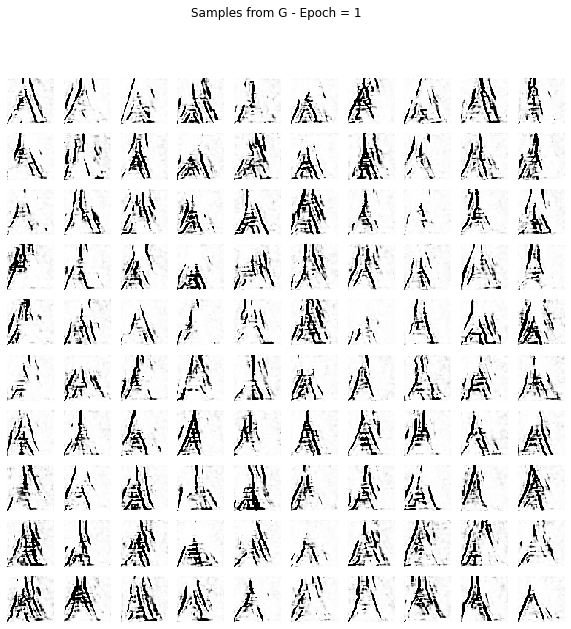

 10%|▉         | 29/300 [23:04<3:33:30, 47.27s/it]

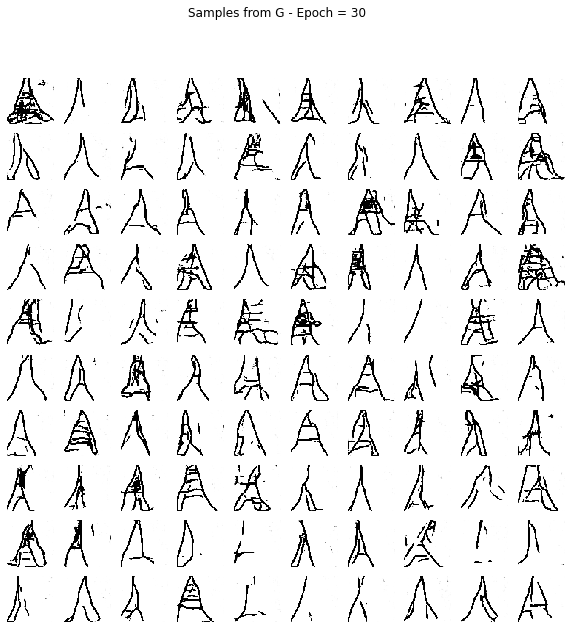

 20%|█▉        | 59/300 [46:49<3:09:24, 47.16s/it]

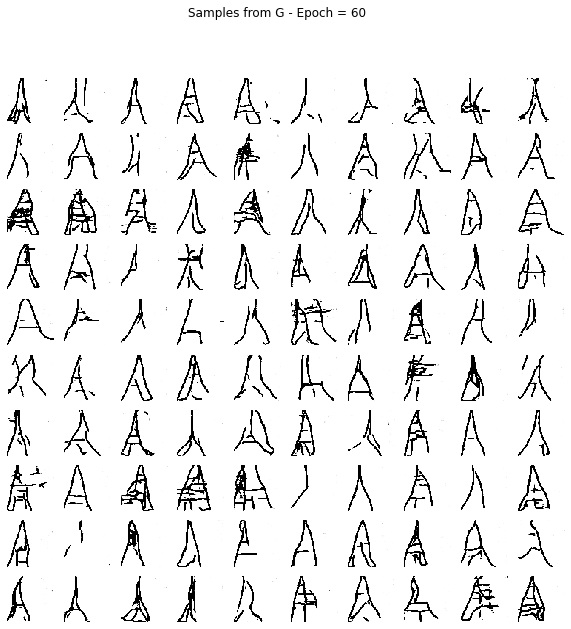

 30%|██▉       | 89/300 [1:10:34<2:46:11, 47.26s/it]

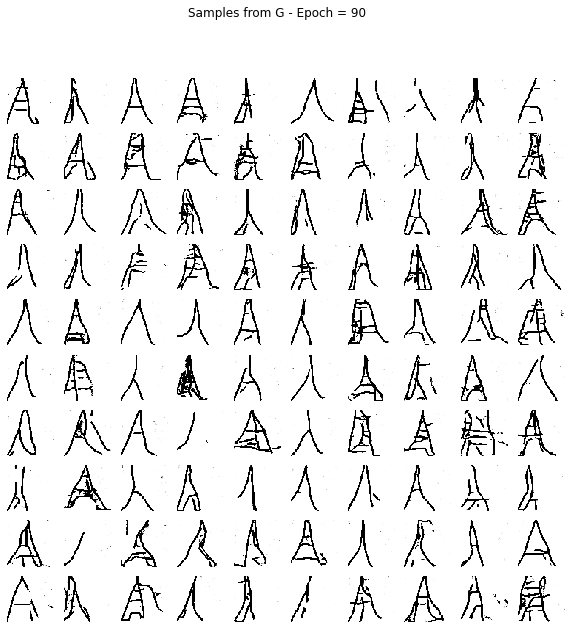

 40%|███▉      | 119/300 [1:34:18<2:22:30, 47.24s/it]

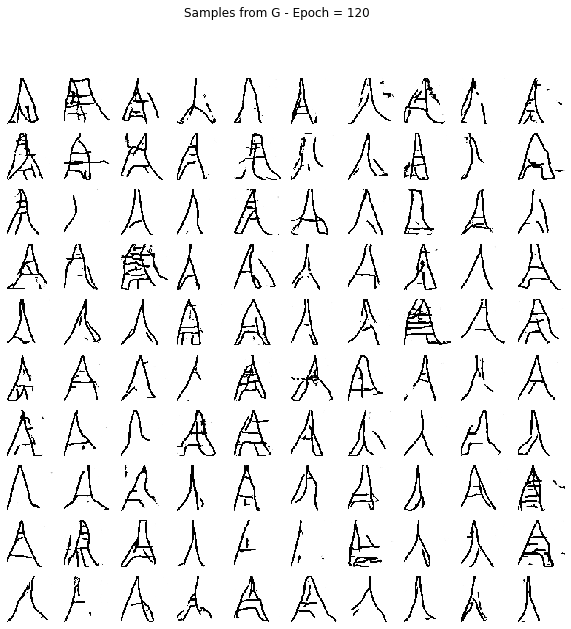

 50%|████▉     | 149/300 [1:58:03<1:57:48, 46.81s/it]

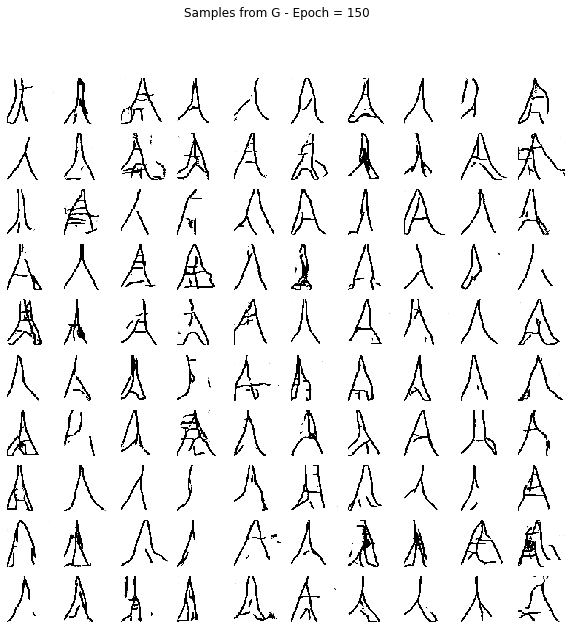

 60%|█████▉    | 179/300 [2:21:47<1:34:27, 46.84s/it]

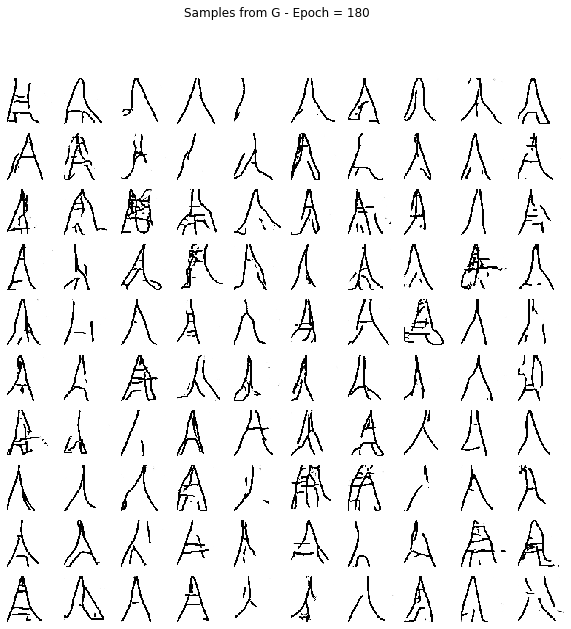

 70%|██████▉   | 209/300 [2:45:31<1:11:01, 46.83s/it]

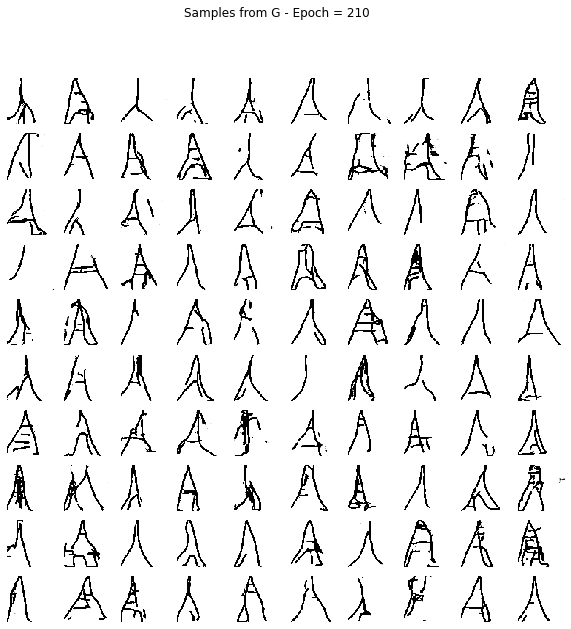

 80%|███████▉  | 239/300 [3:09:15<48:18, 47.51s/it]  

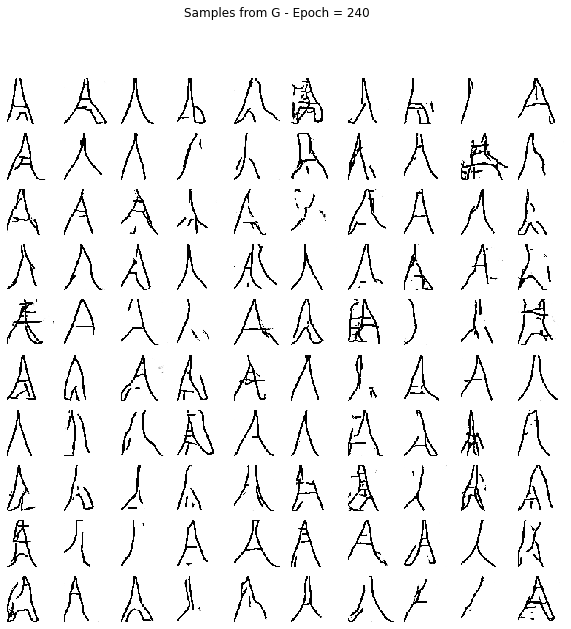

 90%|████████▉ | 269/300 [3:32:59<24:30, 47.43s/it]

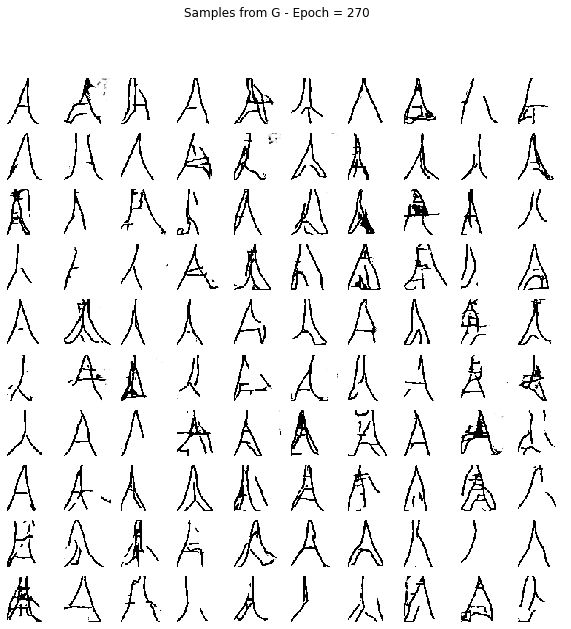

100%|█████████▉| 299/300 [3:56:44<00:47, 47.13s/it]

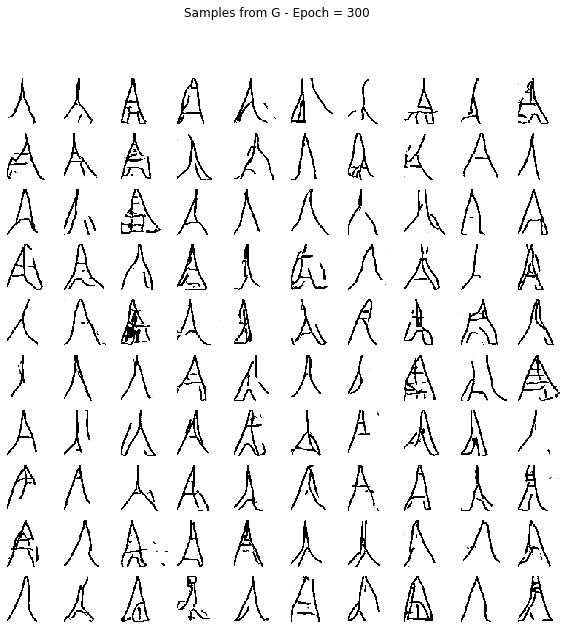

100%|██████████| 300/300 [3:57:29<00:00, 47.50s/it]


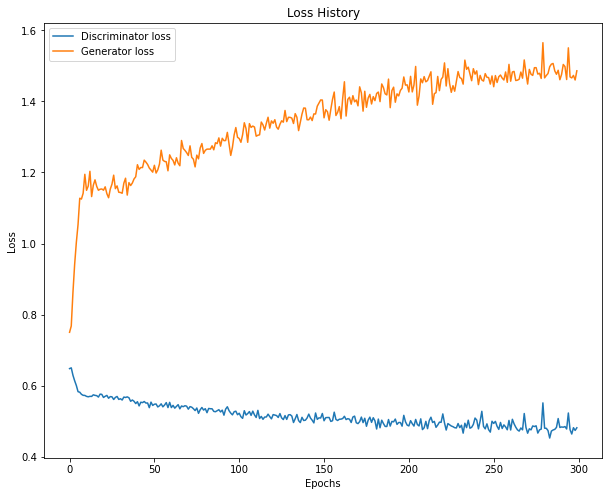

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)            

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 1)         3532801   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 239361    
Total params: 3,772,162
Trainable params: 3,532,161
Non-trainable params: 240,001
_________________________________________________________________


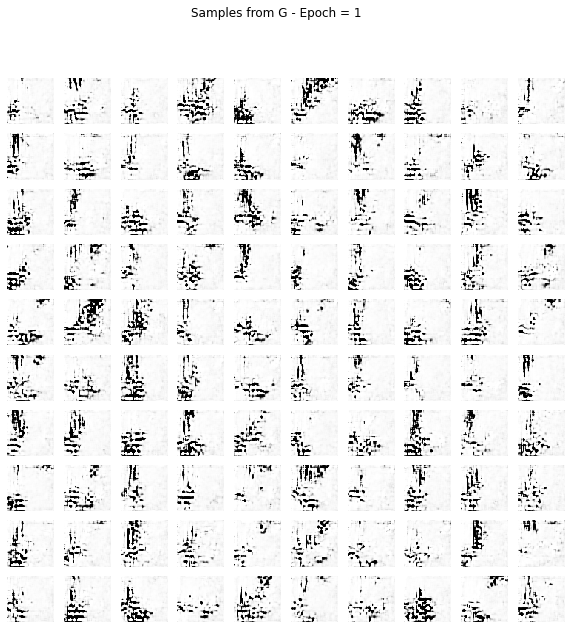

 10%|▉         | 29/300 [22:59<3:33:05, 47.18s/it]

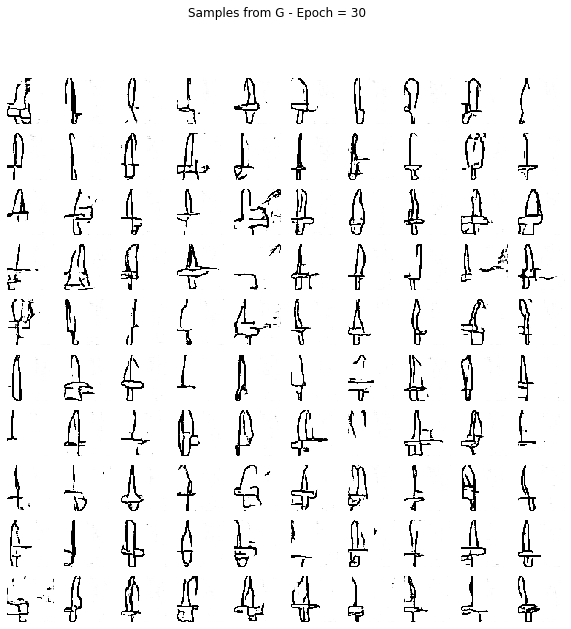

 20%|█▉        | 59/300 [46:44<3:09:37, 47.21s/it]

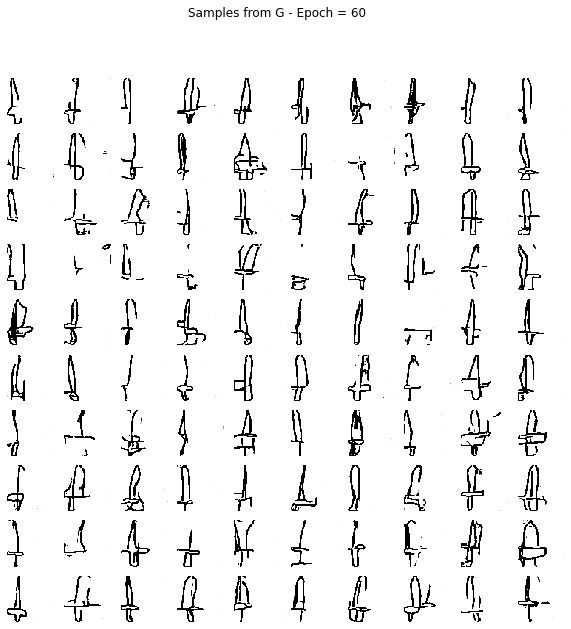

 30%|██▉       | 89/300 [1:10:30<2:46:12, 47.26s/it]

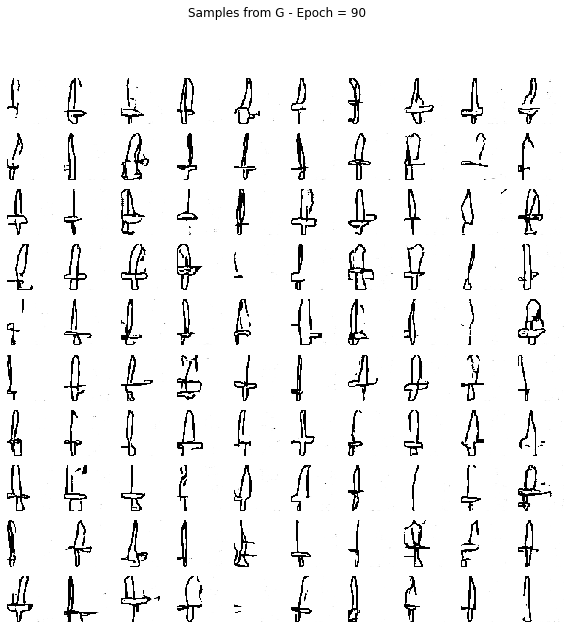

 40%|███▉      | 119/300 [1:34:16<2:23:25, 47.54s/it]

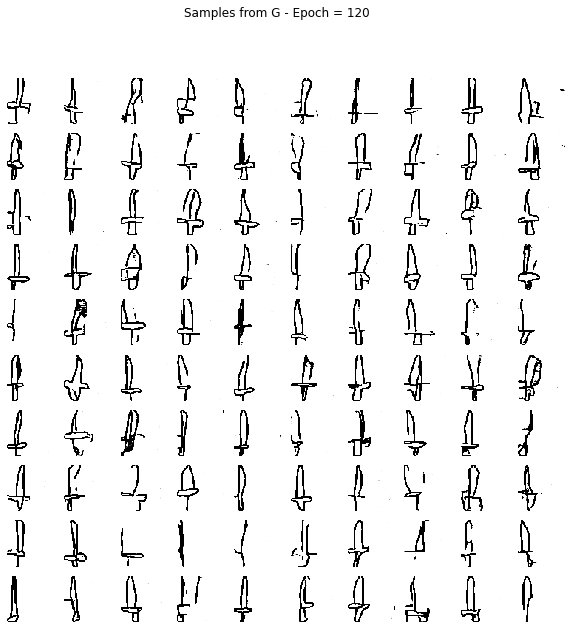

 50%|████▉     | 149/300 [1:58:02<1:59:21, 47.43s/it]

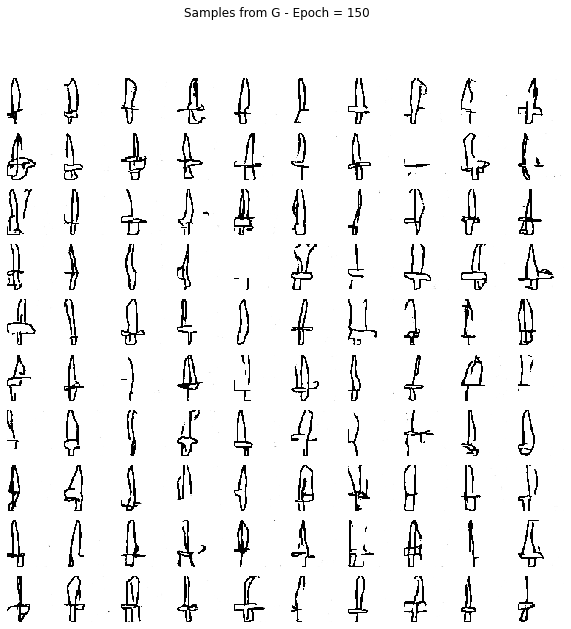

 60%|█████▉    | 179/300 [2:21:47<1:35:37, 47.42s/it]

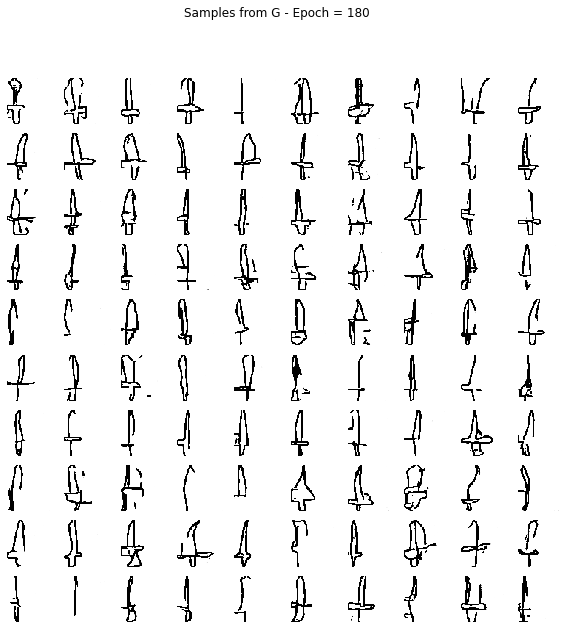

 70%|██████▉   | 209/300 [2:45:32<1:11:53, 47.40s/it]

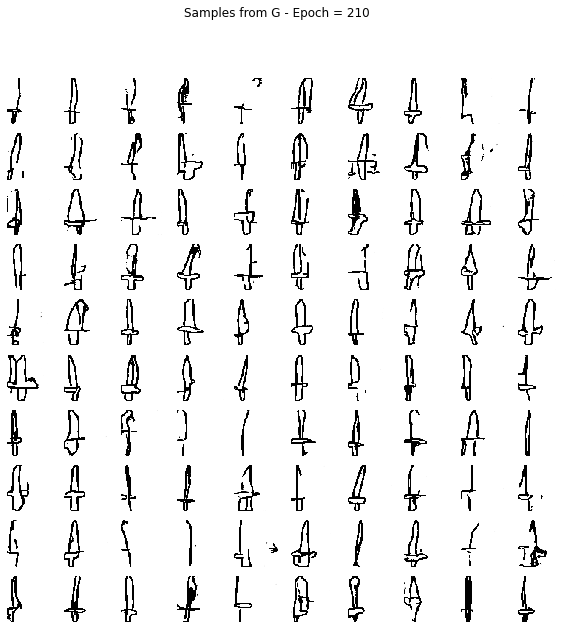

 80%|███████▉  | 239/300 [3:09:18<48:03, 47.27s/it]  

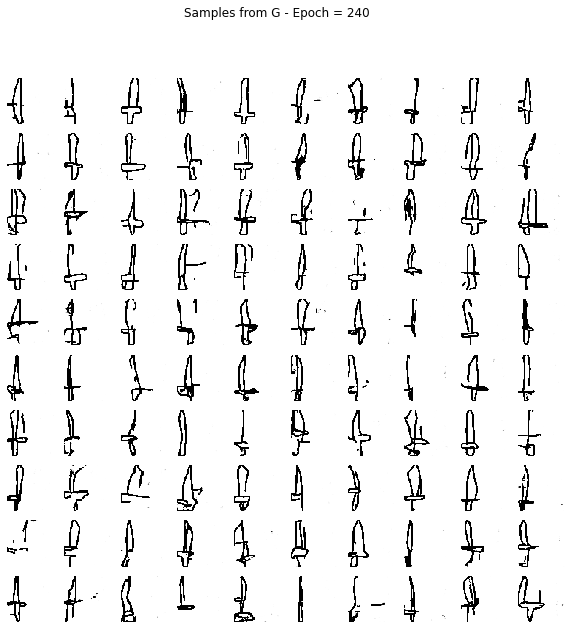

 90%|████████▉ | 269/300 [3:33:03<24:27, 47.33s/it]

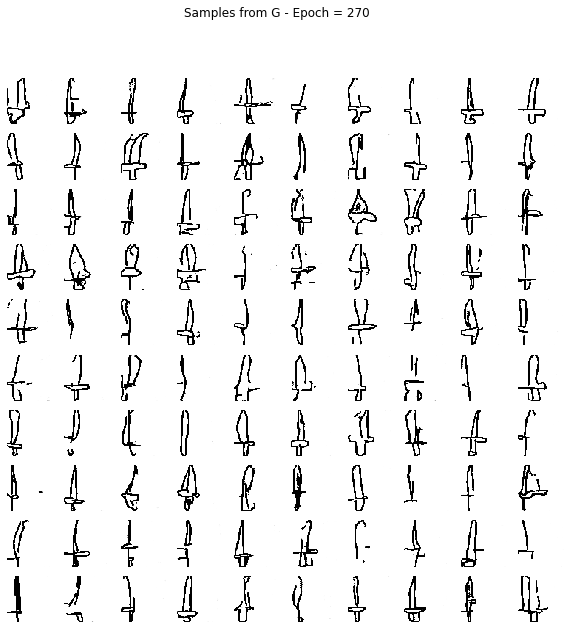

100%|█████████▉| 299/300 [3:56:48<00:46, 46.70s/it]

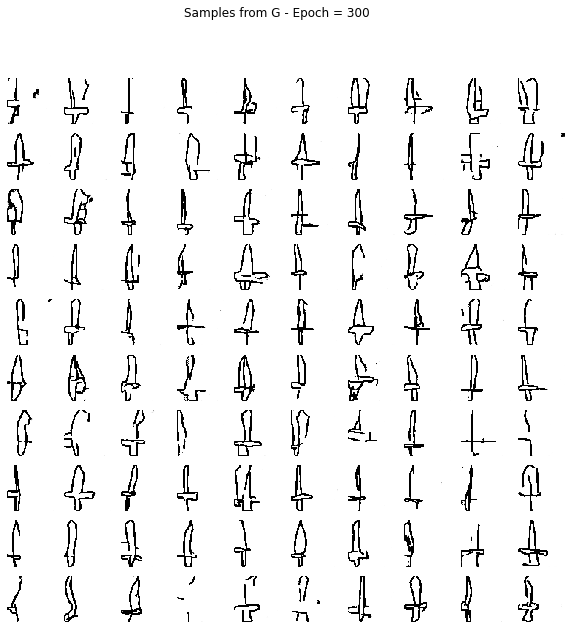

100%|██████████| 300/300 [3:57:34<00:00, 47.51s/it]


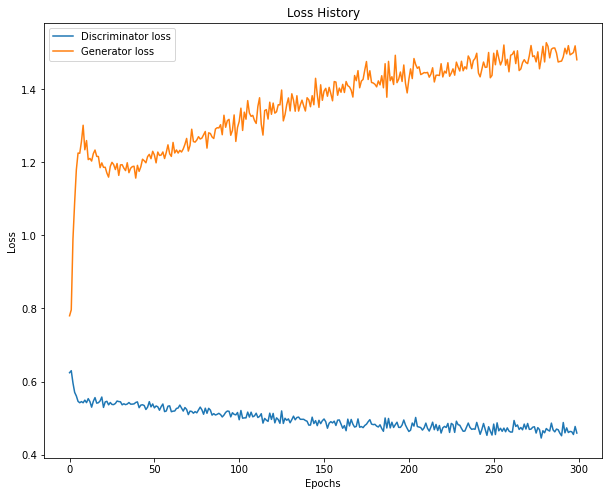

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)            

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 1)         3532801   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 239361    
Total params: 3,772,162
Trainable params: 3,532,161
Non-trainable params: 240,001
_________________________________________________________________


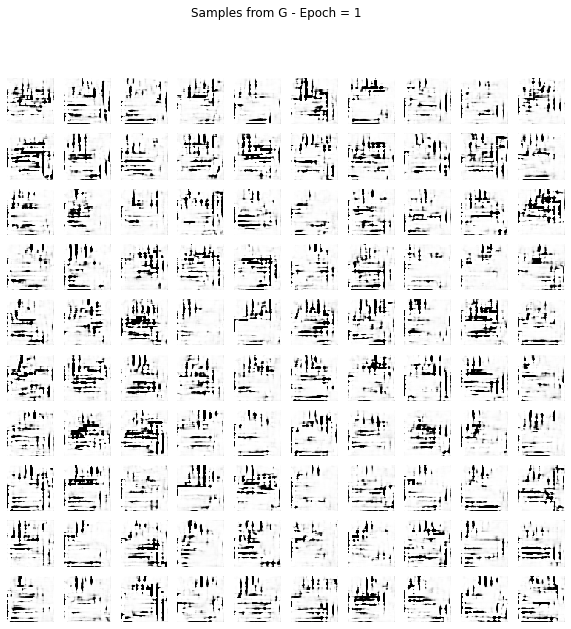

 10%|▉         | 29/300 [22:51<3:33:17, 47.22s/it]

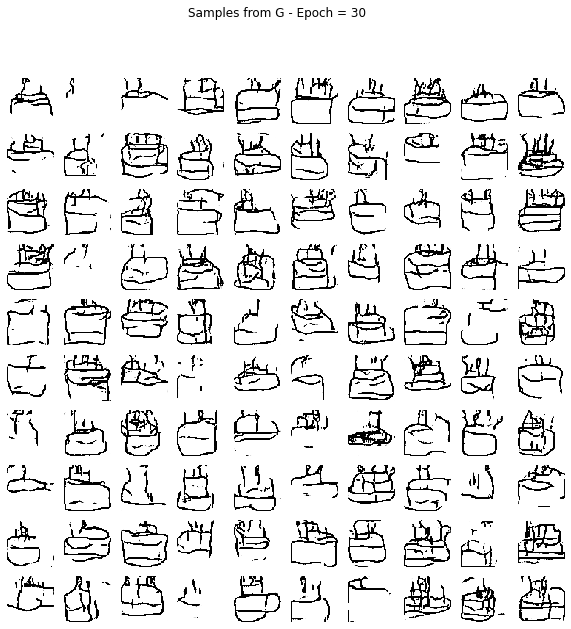

 20%|█▉        | 59/300 [46:29<3:09:48, 47.25s/it]

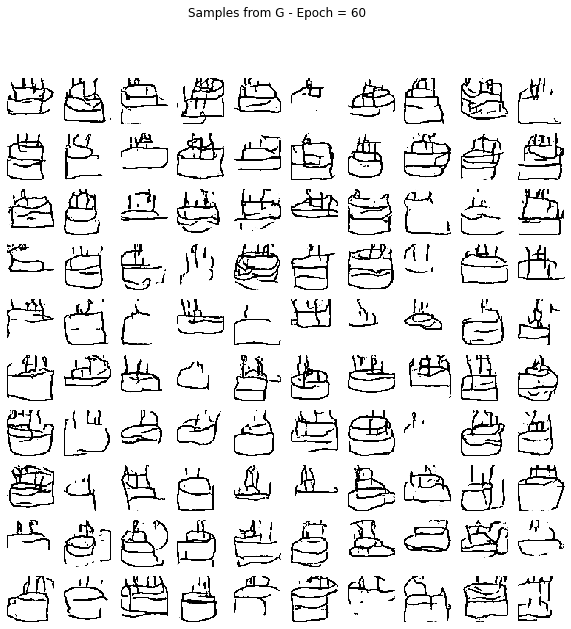

 30%|██▉       | 89/300 [1:10:07<2:45:08, 46.96s/it]

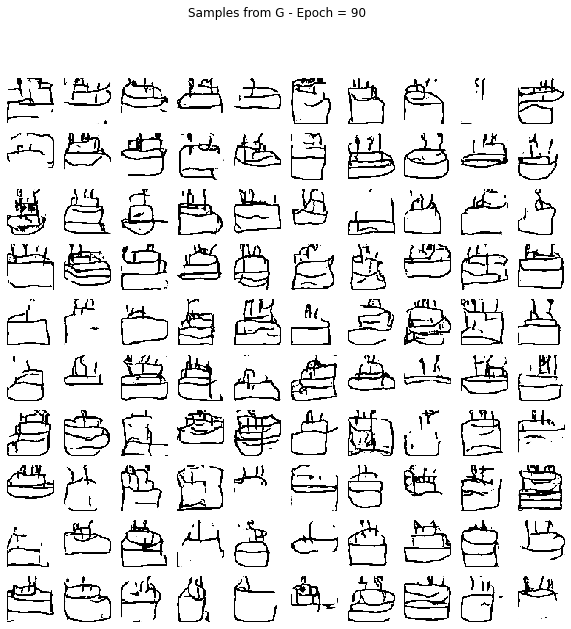

 40%|███▉      | 119/300 [1:33:44<2:21:47, 47.01s/it]

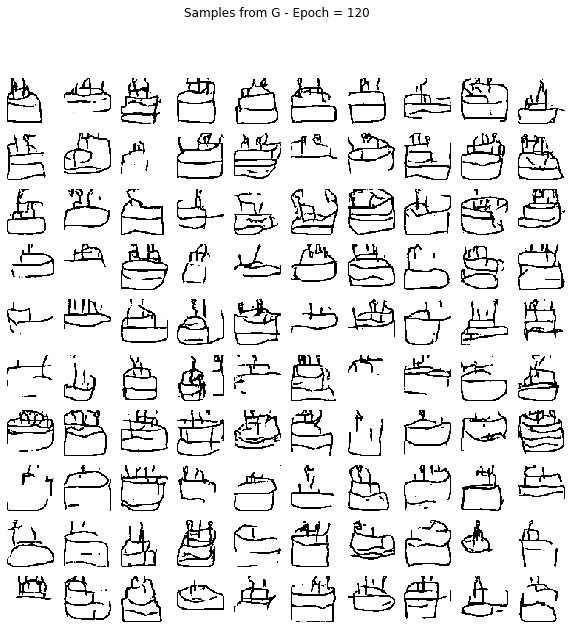

 50%|████▉     | 149/300 [1:57:22<1:58:16, 47.00s/it]

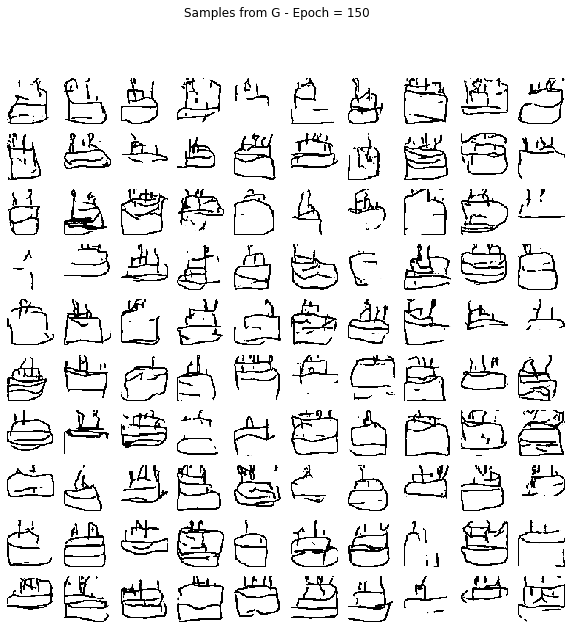

 60%|█████▉    | 179/300 [2:21:00<1:34:44, 46.98s/it]

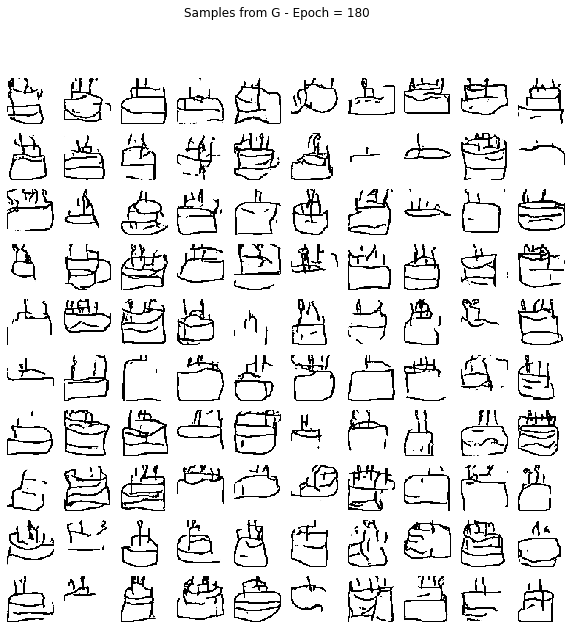

 70%|██████▉   | 209/300 [2:44:37<1:11:08, 46.90s/it]

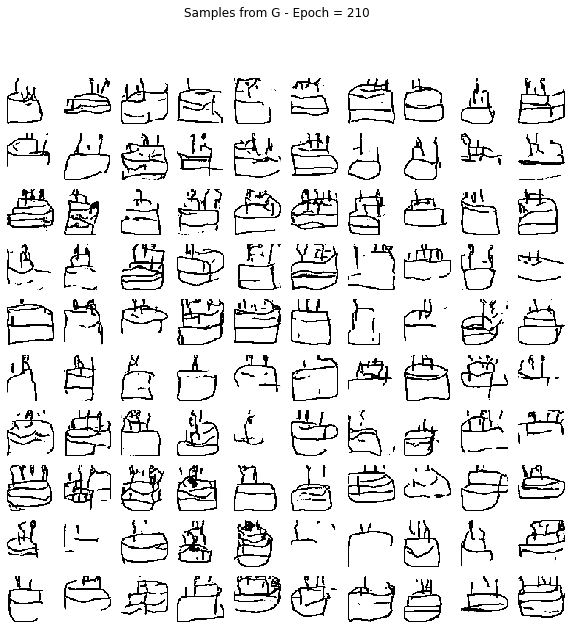

 80%|███████▉  | 239/300 [3:08:14<48:00, 47.21s/it]  

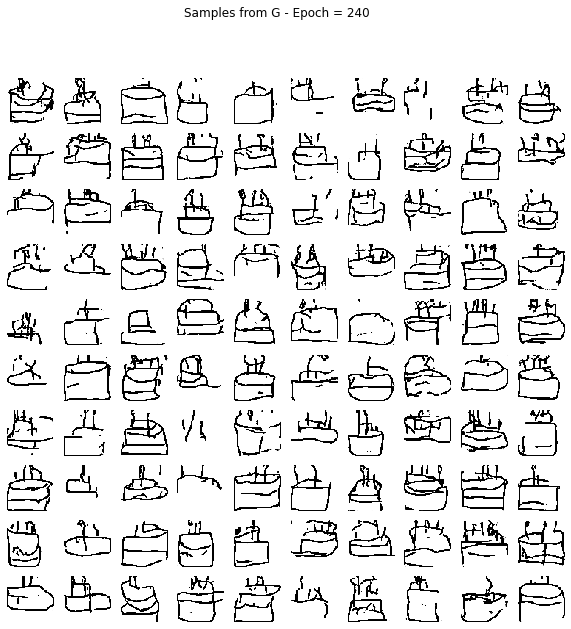

 90%|████████▉ | 269/300 [3:31:58<24:25, 47.28s/it]

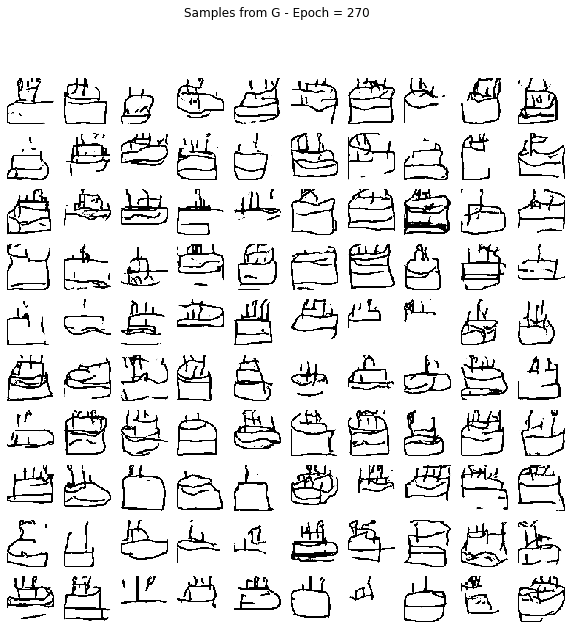

100%|█████████▉| 299/300 [3:55:39<00:47, 47.12s/it]

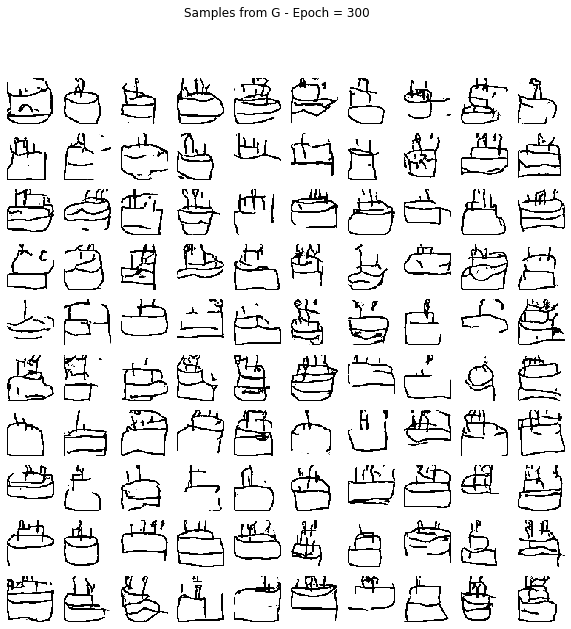

100%|██████████| 300/300 [3:56:25<00:00, 47.28s/it]


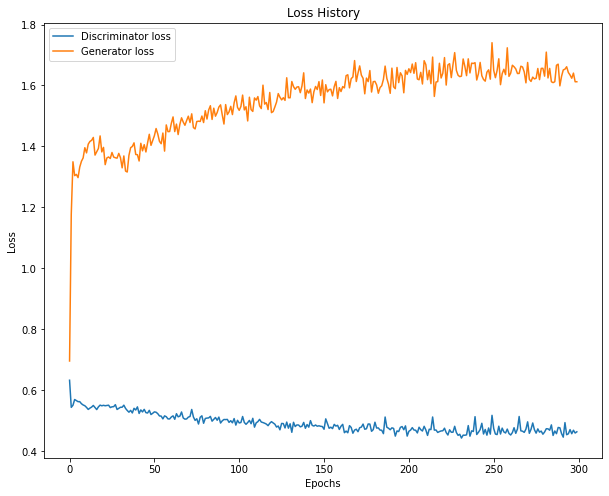

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)            

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 1)         3532801   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 239361    
Total params: 3,772,162
Trainable params: 3,532,161
Non-trainable params: 240,001
_________________________________________________________________


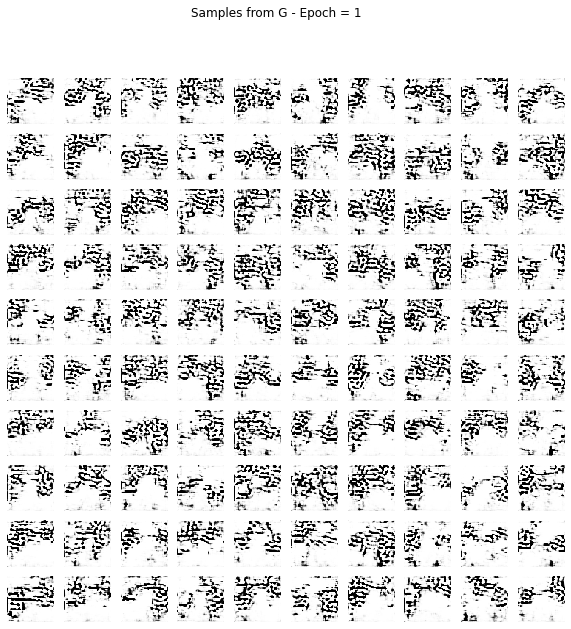

 10%|▉         | 29/300 [23:02<3:32:47, 47.11s/it]

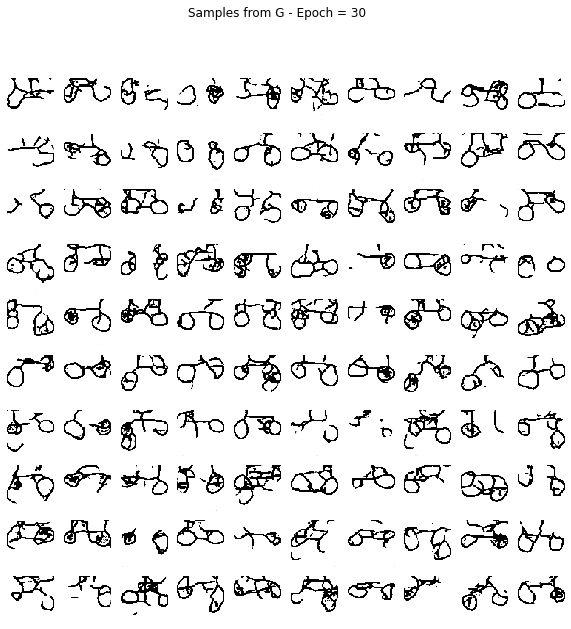

 20%|█▉        | 59/300 [46:50<3:09:05, 47.07s/it]

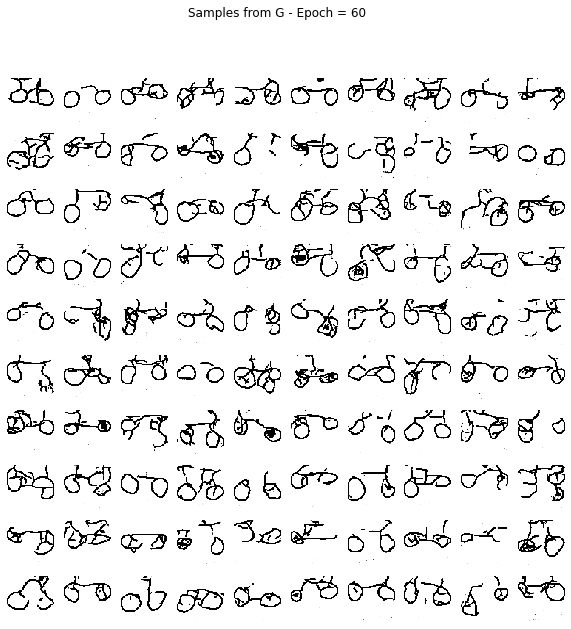

 30%|██▉       | 89/300 [1:10:39<2:43:49, 46.59s/it]

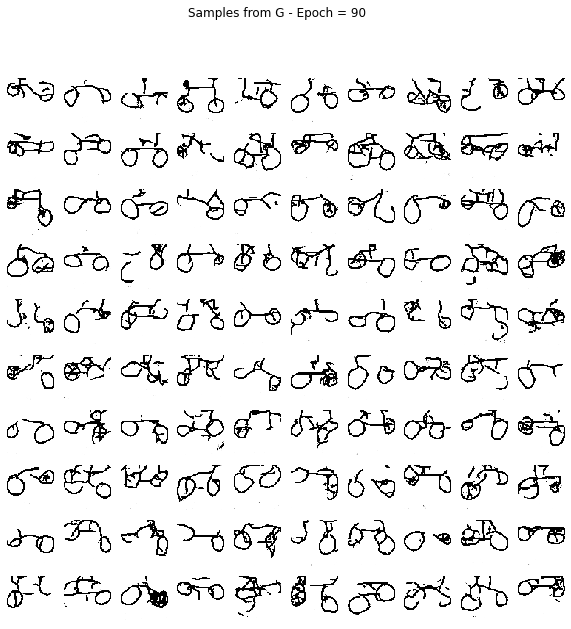

 40%|███▉      | 119/300 [1:34:26<2:19:57, 46.39s/it]

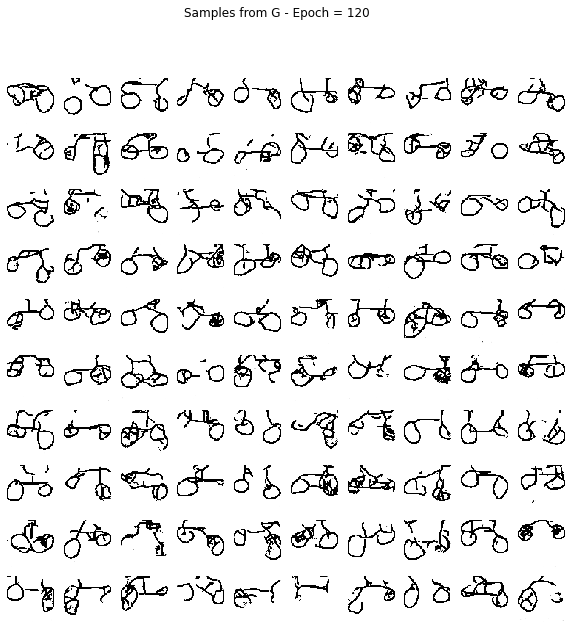

 50%|████▉     | 149/300 [1:58:14<1:58:25, 47.06s/it]

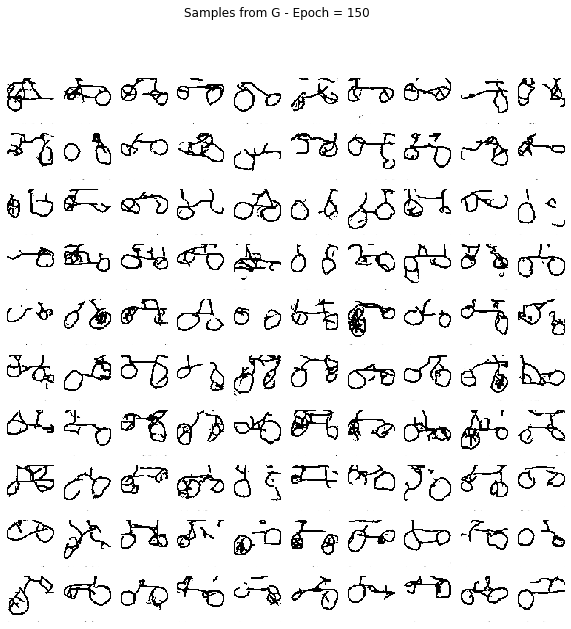

 60%|█████▉    | 179/300 [2:22:02<1:34:51, 47.04s/it]

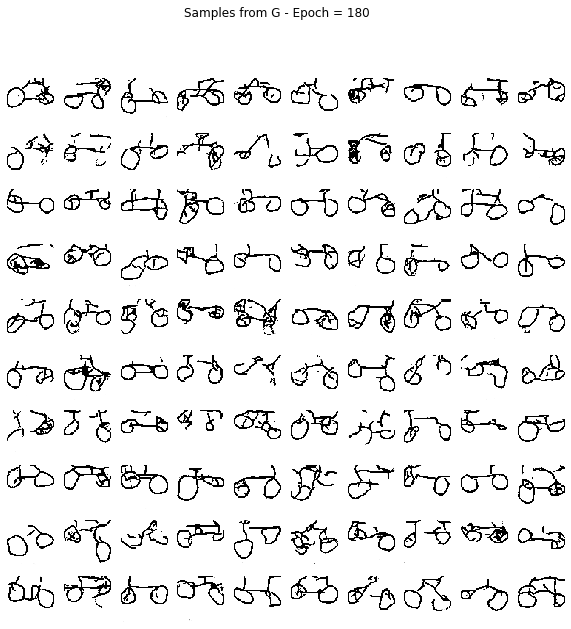

 70%|██████▉   | 209/300 [2:45:48<1:11:18, 47.02s/it]

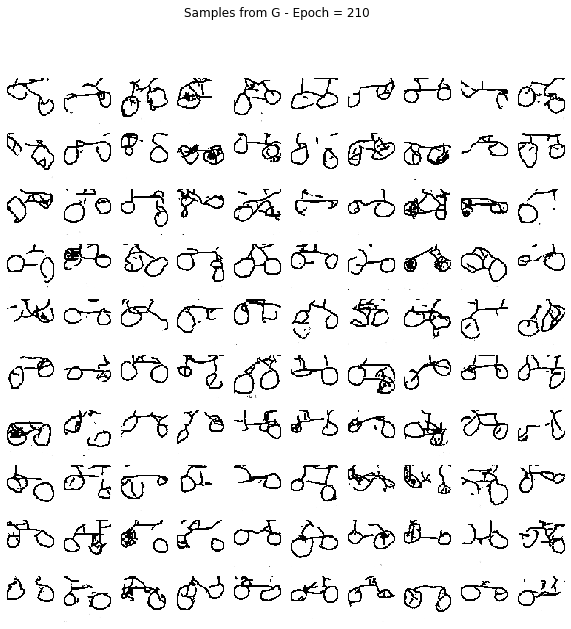

 80%|███████▉  | 239/300 [3:09:36<47:20, 46.56s/it]  

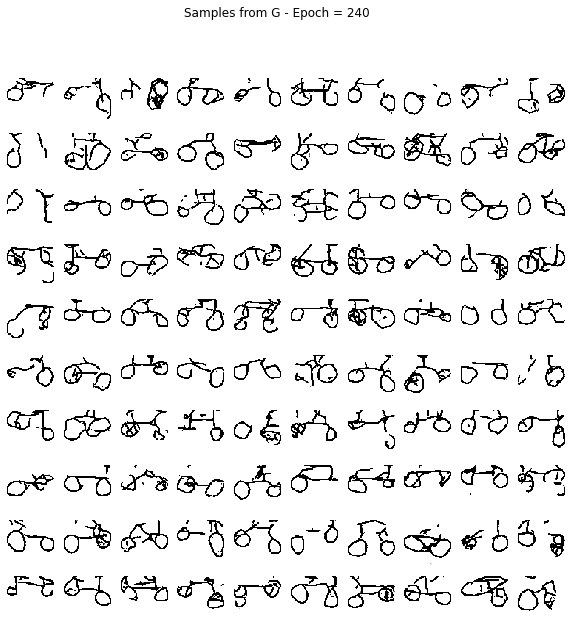

 90%|████████▉ | 269/300 [3:33:25<24:03, 46.55s/it]

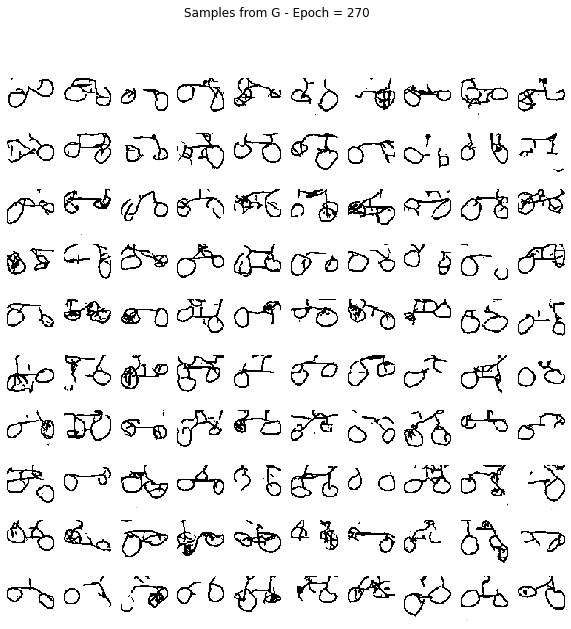

100%|█████████▉| 299/300 [3:57:13<00:46, 46.45s/it]

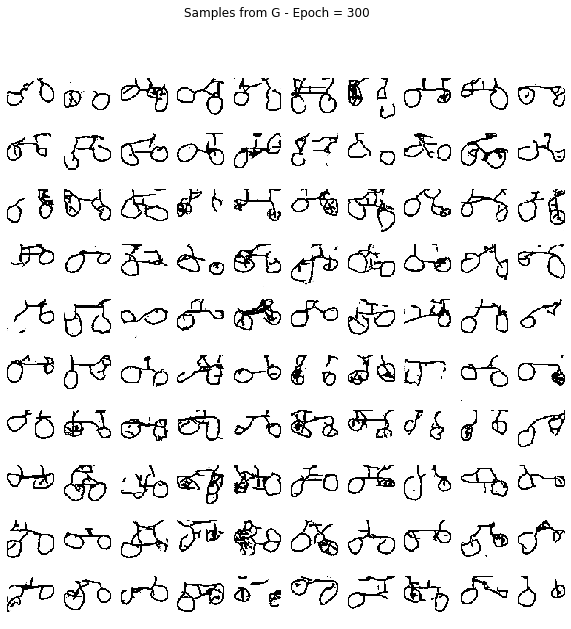

100%|██████████| 300/300 [3:58:00<00:00, 47.60s/it]


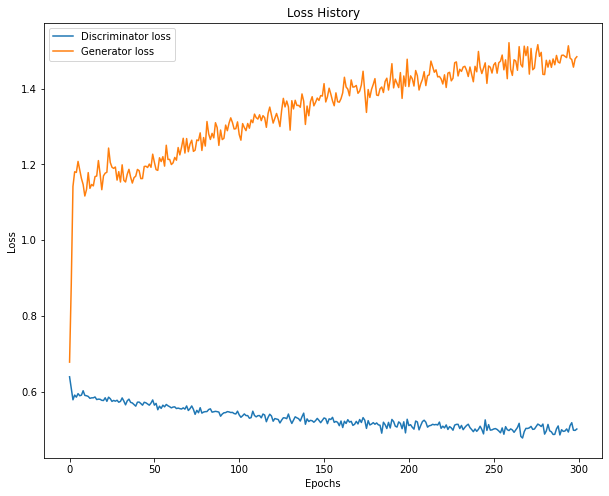

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)            

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 1)         3532801   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 239361    
Total params: 3,772,162
Trainable params: 3,532,161
Non-trainable params: 240,001
_________________________________________________________________


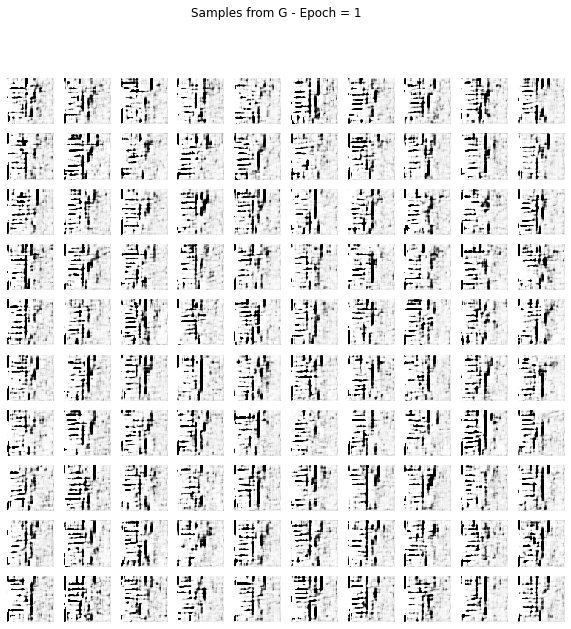

 10%|▉         | 29/300 [23:00<3:34:28, 47.49s/it]

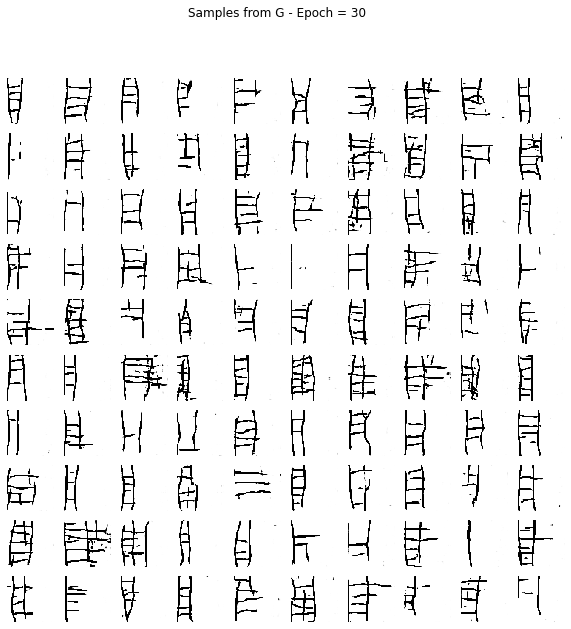

 20%|█▉        | 59/300 [46:44<3:08:03, 46.82s/it]

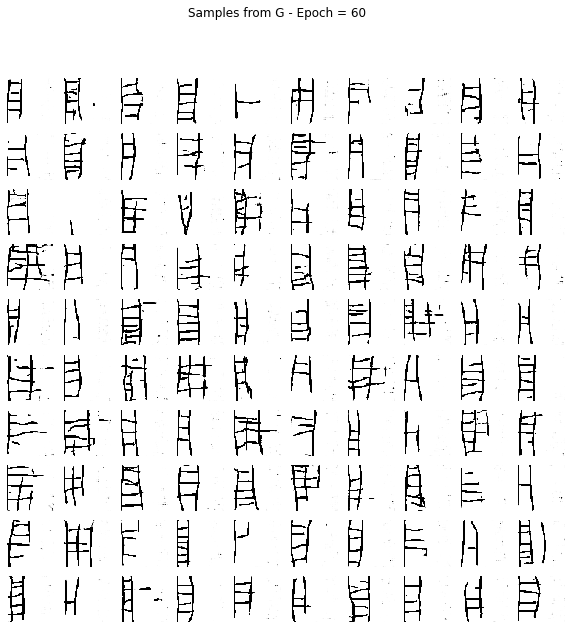

 30%|██▉       | 89/300 [1:10:28<2:44:38, 46.82s/it]

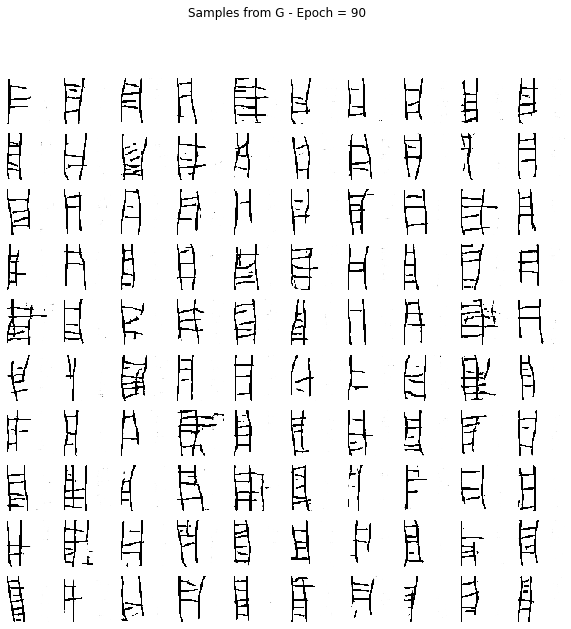

 40%|███▉      | 119/300 [1:34:13<2:20:57, 46.72s/it]

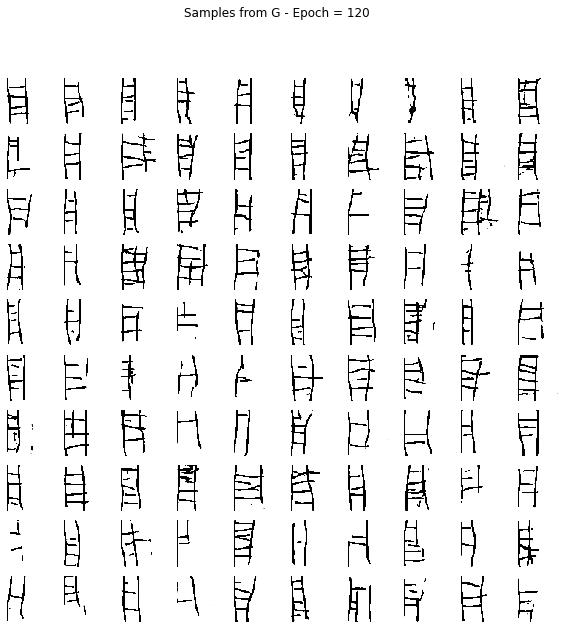

 50%|████▉     | 149/300 [1:57:57<1:57:22, 46.64s/it]

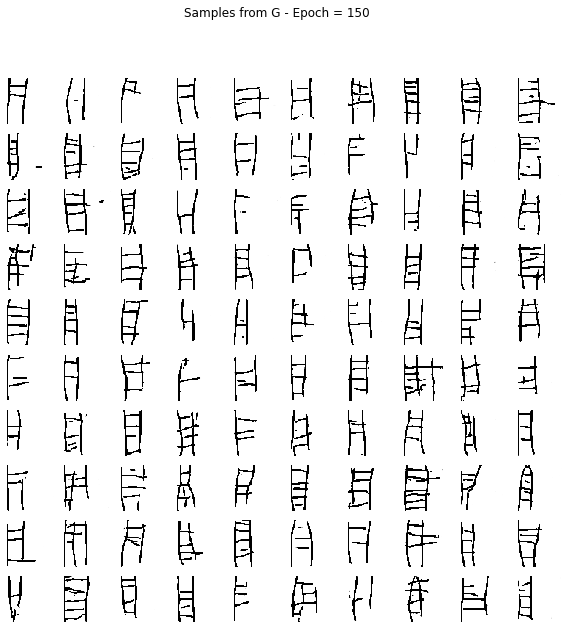

 60%|█████▉    | 179/300 [2:21:42<1:33:59, 46.60s/it]

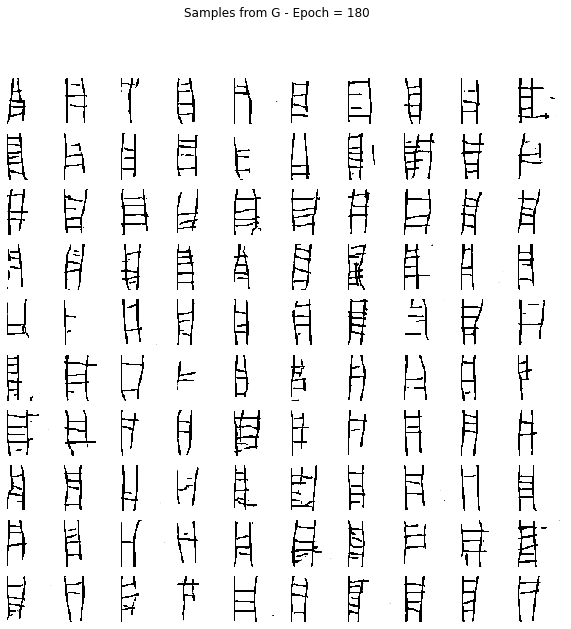

 70%|██████▉   | 209/300 [2:45:27<1:10:28, 46.47s/it]

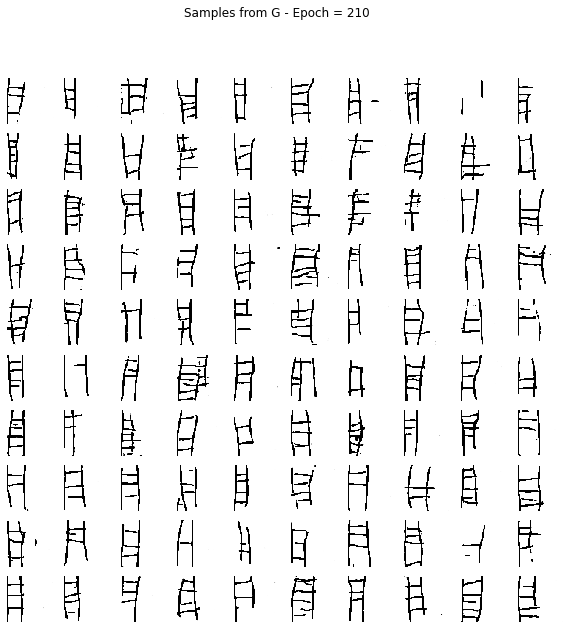

 80%|███████▉  | 239/300 [3:09:10<46:27, 45.70s/it]  

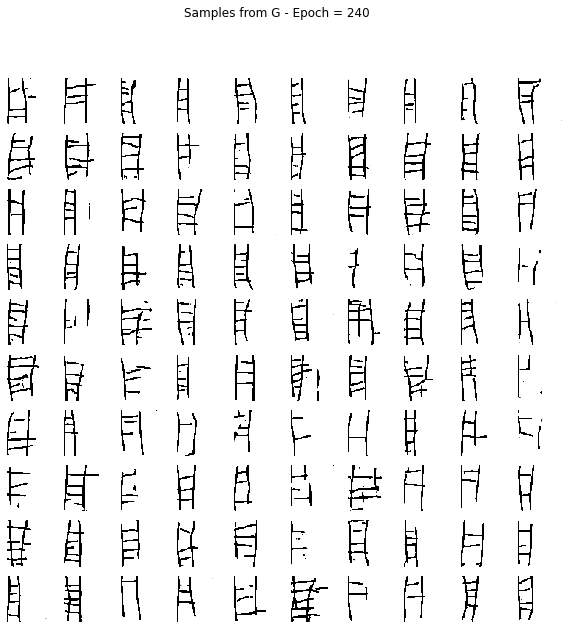

 90%|████████▉ | 269/300 [3:32:55<24:00, 46.48s/it]

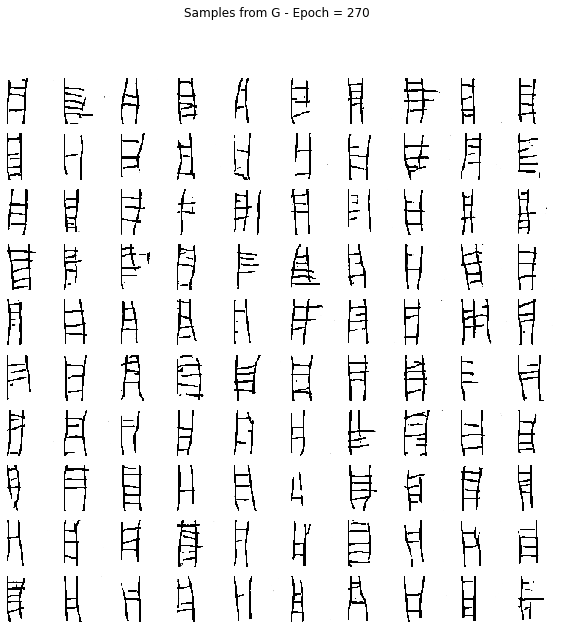

100%|█████████▉| 299/300 [3:56:39<00:46, 46.51s/it]

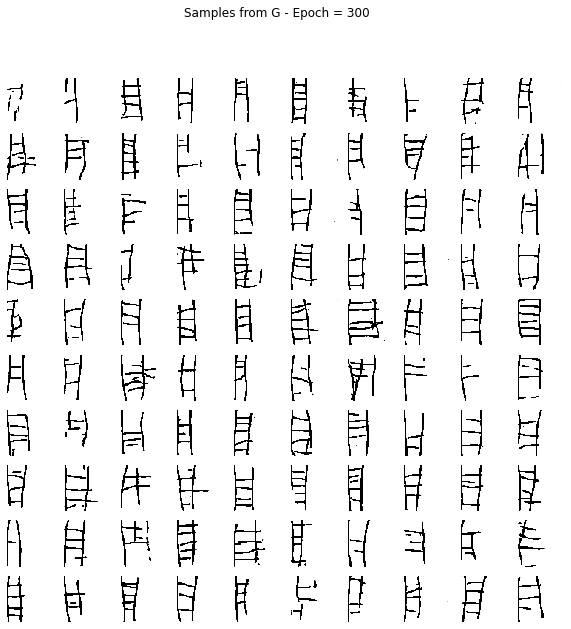

100%|██████████| 300/300 [3:57:27<00:00, 47.49s/it]


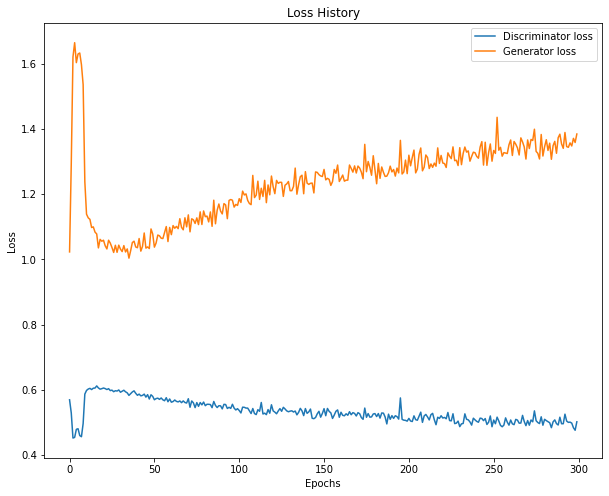

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)           

  0%|          | 0/300 [00:00<?, ?it/s]

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 1)         3532801   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 239361    
Total params: 3,772,162
Trainable params: 3,532,161
Non-trainable params: 240,001
_________________________________________________________________


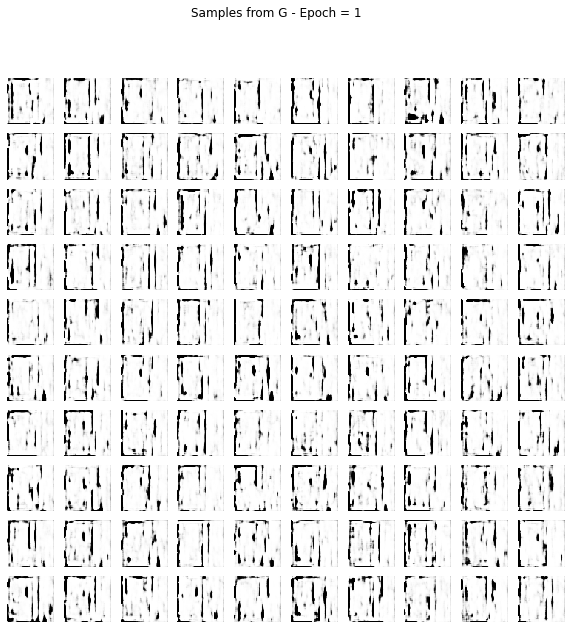

 10%|▉         | 29/300 [22:58<3:30:03, 46.51s/it]

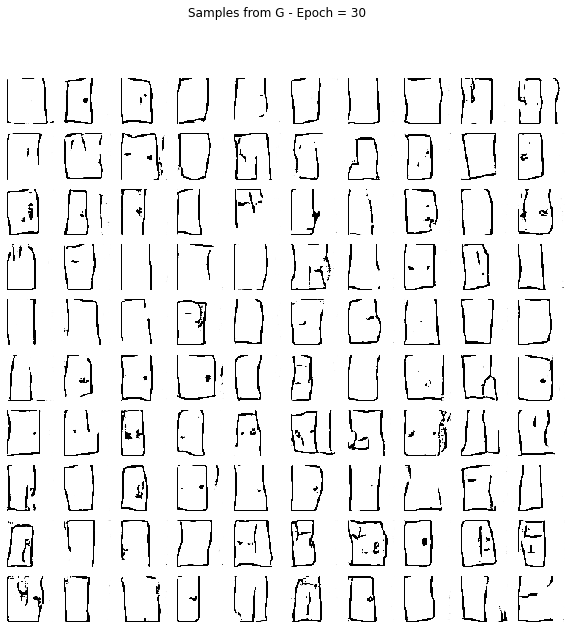

 20%|█▉        | 59/300 [46:43<3:06:29, 46.43s/it]

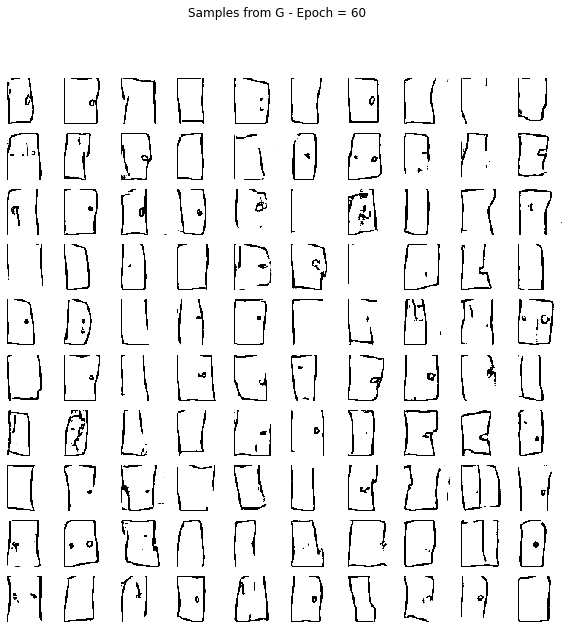

 30%|██▉       | 89/300 [1:10:25<2:42:52, 46.31s/it]

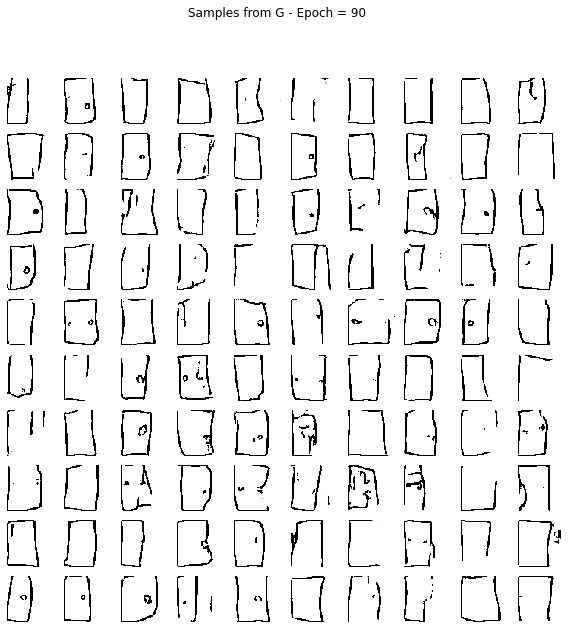

 40%|███▉      | 119/300 [1:34:08<2:19:55, 46.38s/it]

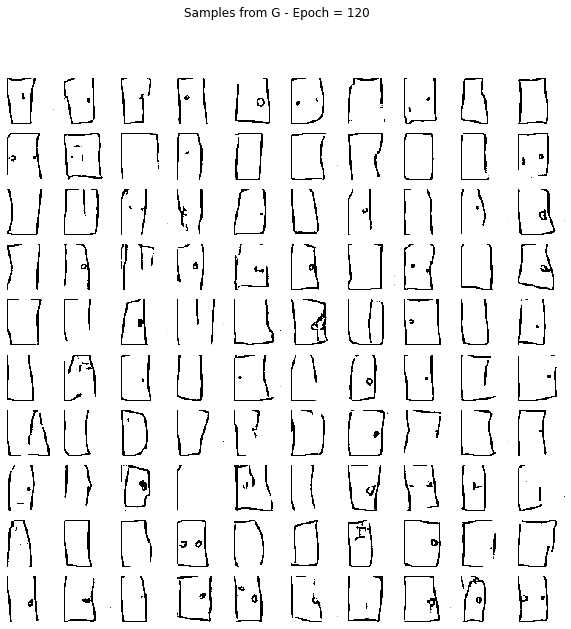

 50%|████▉     | 149/300 [1:57:49<1:54:54, 45.66s/it]

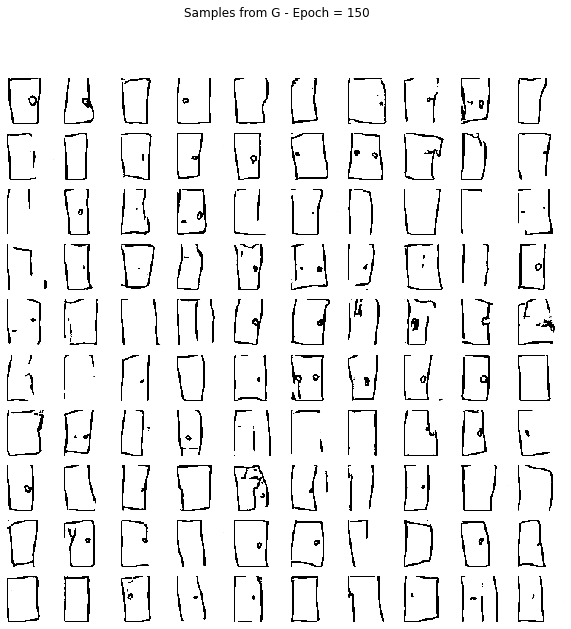

 60%|█████▉    | 179/300 [2:21:31<1:33:28, 46.35s/it]

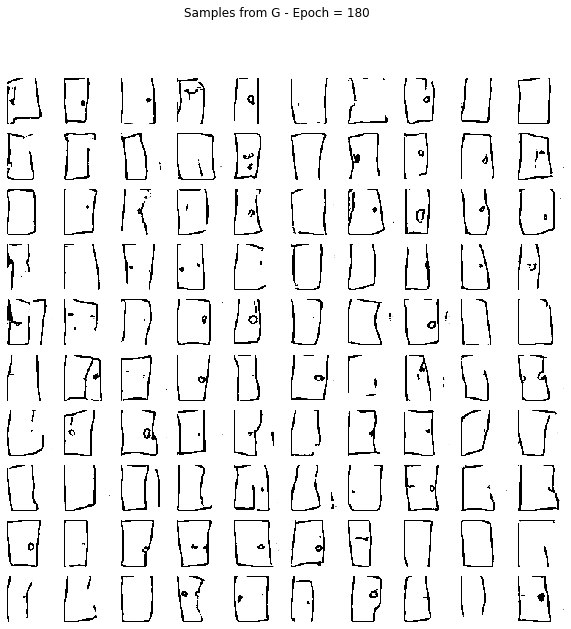

 70%|██████▉   | 209/300 [2:45:16<1:10:23, 46.41s/it]

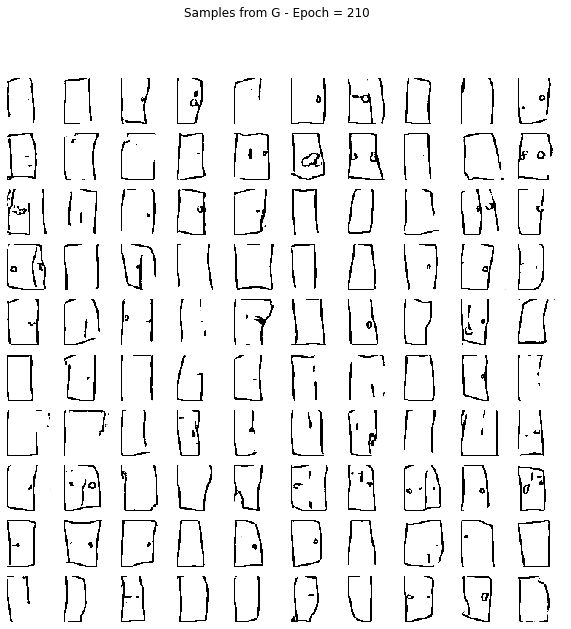

 80%|███████▉  | 239/300 [3:08:59<47:06, 46.34s/it]  

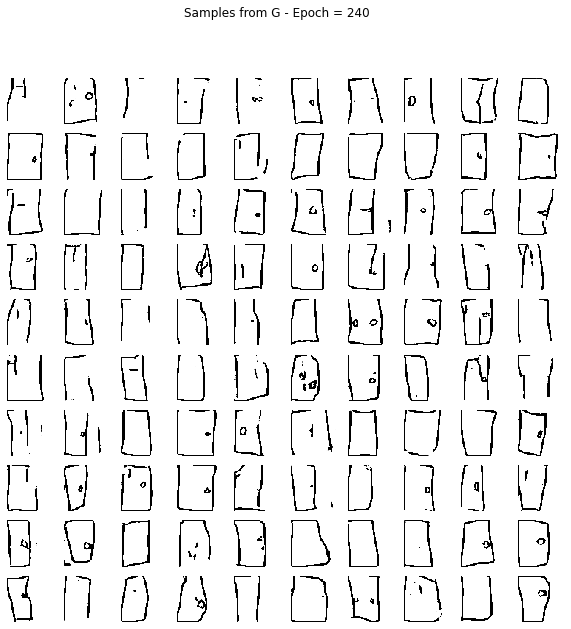

 90%|████████▉ | 269/300 [3:32:44<24:01, 46.49s/it]

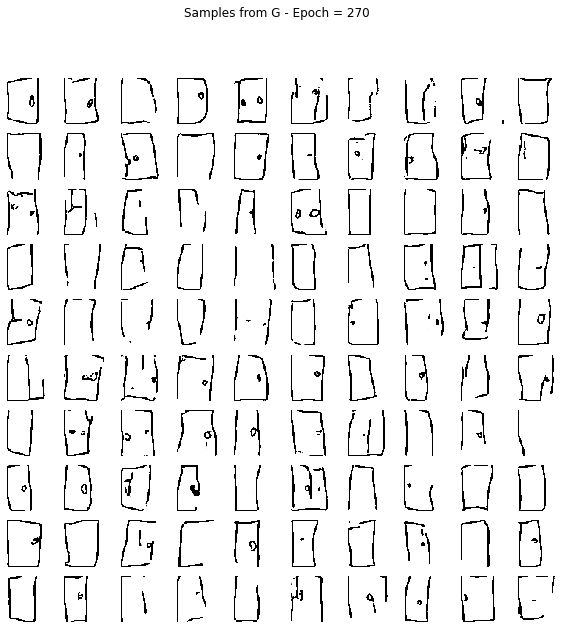

100%|█████████▉| 299/300 [3:56:27<00:45, 45.92s/it]

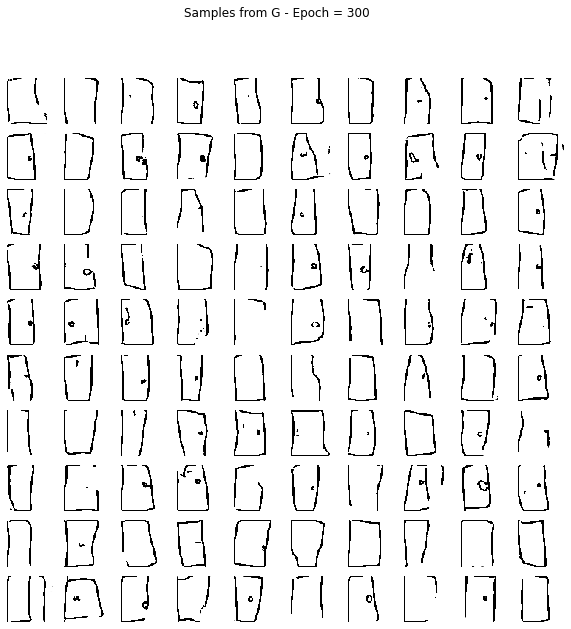

100%|██████████| 300/300 [3:56:55<00:00, 47.38s/it]


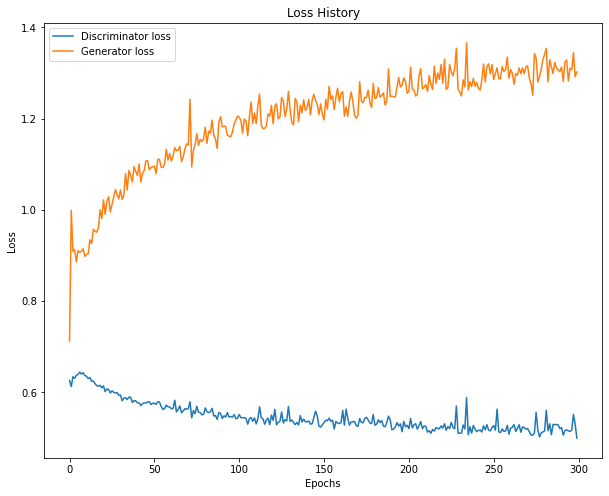

In [7]:
for item in df_gan:
    X_train = (df_gan[item].astype(np.float32)/0.5) - 1. #normalize to be [-1,1]
    num_train = X_train.shape[0]
    X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
    gan = DCGAN()
    gan.train(X_train, epochs=300, batch_size=128, sample_interval=30)
    f_name = 'GAN_'+item+'.h5'
    gan.generator.save(f_name)